In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from dataloader import *

### Load data

In [11]:
# Define data file names and paths
DATA_NAME = '20250324_rhino_10_52-15_43'
DATA_DIR =  'DATA'
OUTPUT_DIR = 'OUTPUT'

# Define data file path
ZOODATA = f'{DATA_DIR}/{DATA_NAME}.txt'

# Load data
zoodata_dl = Dataloader.read_file(ZOODATA) 

In [12]:
imu_data = np.array(zoodata_dl.raw_data)
imu_data_avg = []

for row in imu_data:
    avg = np.abs(np.mean(row[-3:]))
    imu_data_avg.append(avg)

imu_data_avg = np.array(imu_data_avg) 

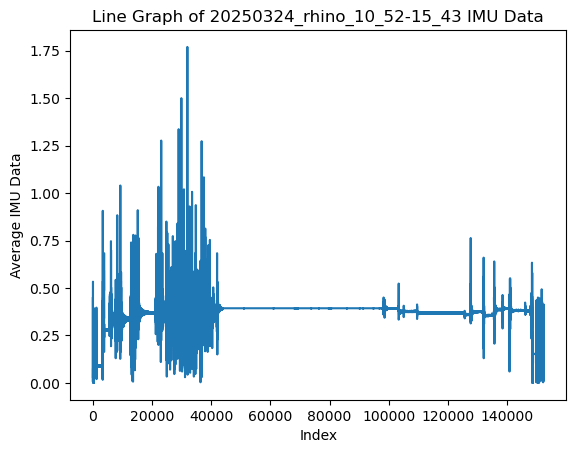

In [13]:
plt.plot(range(len(imu_data_avg)), imu_data_avg)
plt.xlabel('Index')
plt.ylabel('Average IMU Data')
plt.title(f'Line Graph of {DATA_NAME} IMU Data')
plt.show()

### Take xyz average of each reading

In [14]:
start_time = "2025 3 24 12 12 30"
end_time = "2025 3 24 14 50 45"
zoodata_dl = zoodata_dl.crop(start_time, end_time)

Start time: 2025-03-24 12:12:30, End time: 2025-03-24 14:50:45


In [15]:
imu_data = np.array(zoodata_dl.raw_data)
imu_data_avg = []

for row in imu_data:
    avg = np.abs(np.mean(row[-3:]))
    imu_data_avg.append(avg)

imu_data_avg = np.array(imu_data_avg) 

### Graph

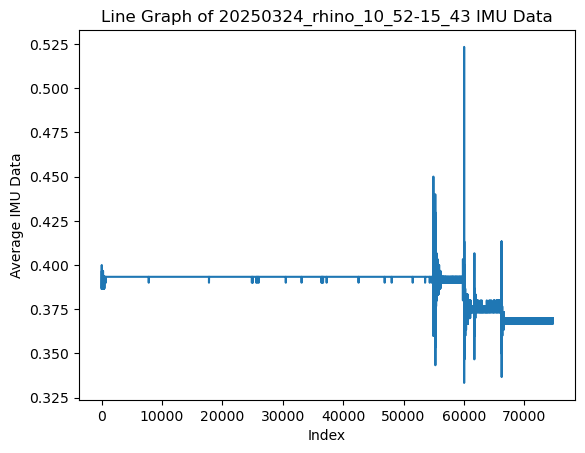

In [16]:
plt.plot(range(len(imu_data_avg)), imu_data_avg)
plt.xlabel('Index')
plt.ylabel('Average IMU Data')
plt.title(f'Line Graph of {DATA_NAME} IMU Data')
plt.show()

### Get average acceleration per interval of time

In [17]:
time = imu_data[:, :6]
imu_data_avg_time = np.column_stack((time, imu_data_avg))

# specify interval of time and units of duration
interval = 3 # col 4 = minutes
duration = 4 # col 5 = seconds

# # get the average of the IMU data for each duration
# unique_seconds, unique_indices = np.unique(imu_data_avg_time[:, :5], return_index=True)

# avg_per_second = []

# for sec in unique_seconds:
#     mask = imu_data_avg_time[:, 5] == sec
#     avg_per_second.append(np.mean(imu_data_avg_time[mask, -1]))

# avg_per_second = np.array(avg_per_second)

# Get unique time stamps and their indices
unique_times, unique_indices = np.unique(imu_data_avg_time[:, :6], axis=0, return_inverse=True)

# Calculate the average acceleration for each unique time stamp
avg_acceleration = np.array([imu_data_avg_time[unique_indices == i, 6].mean() for i in range(len(unique_times))])

# Combine unique times with their corresponding average accelerations
result = np.column_stack((unique_times, avg_acceleration))
print(result.shape)

# print(avg_per_second)
# print(unique_indices)

(9494, 7)


[[2025    3   24   12    0]
 [2025    3   24   13    0]
 [2025    3   24   14    1]]


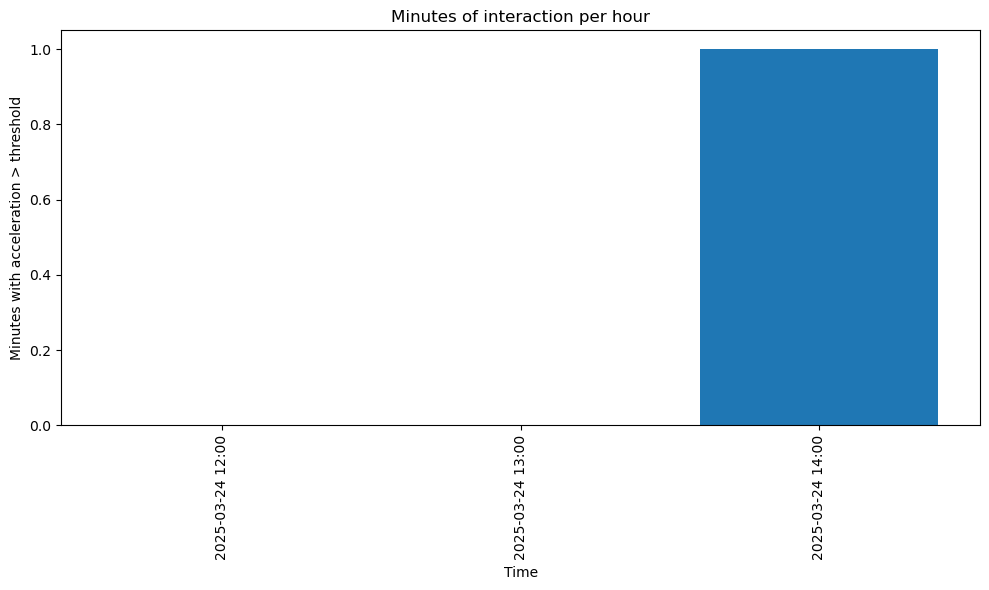

In [18]:
# Define threshold for significant acceleration
threshold = 0.5

# Get time data (year, month, day, hour) and acceleration data
time_data = imu_data[:, :6]  # Time data (year, month, day, hour, minute, second)
accel_data = imu_data_avg    # Average acceleration data

# Combine time data with acceleration data
combined_data = np.column_stack((time_data, accel_data))

# Group by hour (year, month, day, hour)
hours = combined_data[:, :4]
unique_hours = np.unique(hours, axis=0)

# Count minutes with significant acceleration per hour
minutes_per_hour = []

for hour in unique_hours:
    # Get all data for this hour
    mask = np.all(combined_data[:, :4] == hour, axis=1)
    hour_data = combined_data[mask]
    
    # Get unique minutes in this hour
    unique_minutes = np.unique(hour_data[:, 4])
    
    # Count minutes with acceleration > threshold
    minutes_above_threshold = 0
    for minute in unique_minutes:
        minute_mask = hour_data[:, 4] == minute
        minute_data = hour_data[minute_mask]
        if np.any(minute_data[:, 6] > threshold):
            minutes_above_threshold += 1
    
    # Store hour with count of minutes above threshold
    minutes_per_hour.append(np.append(hour, minutes_above_threshold))

# Convert to numpy array
result_with_counts = np.array(minutes_per_hour)

# Save result as CSV
# Convert result_with_counts to integers before saving
result_with_counts = result_with_counts.astype(int)
print(result_with_counts)

np.savetxt(f'{OUTPUT_DIR}/{DATA_NAME}_enrichment_data.csv', 
           result_with_counts, 
           delimiter=',', 
           fmt='%d,%d,%d,%d,%d',
           header='Year,Month,Day,Hour,Minutes_Above_Threshold', 
           comments='')

# Create plot
time_labels = [f'{int(year)}-{int(month):02d}-{int(day):02d} {int(hour):02d}:00' 
              for year, month, day, hour in result_with_counts[:, :4]]
counts = result_with_counts[:, 4]

plt.figure(figsize=(10, 6))
plt.bar(range(len(counts)), counts)
plt.xlabel('Time')
plt.ylabel('Minutes with acceleration > threshold')
plt.title('Minutes of interaction per hour')
plt.xticks(range(len(counts)), time_labels, rotation=90)
plt.tight_layout()
plt.show()

In [19]:
# threshold = 0.5

# # Get unique hour timestamps and their indices
# unique_hours, unique_indices = np.unique(result[:, :4], axis=0, return_inverse=True)

# # Count the number of minutes with acceleration readings greater than the threshold for each unique hour
# count_above_threshold = np.array([np.sum(result[unique_indices == i, 4] > threshold) for i in range(len(unique_hours))])

# # Combine unique hours with their corresponding counts
# result_with_counts = np.column_stack((unique_hours, count_above_threshold))

# # Save result_with_counts as a CSV file
# np.savetxt(f'{OUTPUT_DIR}/result_with_counts_per_hour.csv', result_with_counts, delimiter=',', header='Year,Month,Day,Hour,Duration(min)', comments='')

# time = result_with_counts[:, :4]
# count = result_with_counts[:, 4]
# # Create a list of labels for the x-axis
# labels = [f'{int(year)}-{int(month):02d}-{int(day):02d} {int(hour):02d}:00' for year, month, day, hour in time]

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(count)), count)
# plt.xlabel('Time')
# plt.ylabel('Count of minutes with interaction')
# plt.title('Minutes of interaction per hour')
# plt.xticks(range(len(count)), labels, rotation=90)
# plt.tight_layout()
# plt.show()


In [20]:
raise RuntimeError("Stopping the notebook execution.")

RuntimeError: Stopping the notebook execution.

### count duration of interactions per interval of time

In [ ]:
time = imu_data[:, :6]
imu_data_avg_time = np.column_stack((time, imu_data_avg))

# specify interval of time and units of duration
interval = 4 # col 4 = minutes
duration = 5 # col 5 = seconds

# Get unique time stamps and their indices
unique_times, unique_indices = np.unique(imu_data_avg_time[:, :6], axis=0, return_inverse=True)

# Calculate the average acceleration for each unique time stamp
avg_acceleration = np.array([imu_data_avg_time[unique_indices == i, 6].mean() for i in range(len(unique_times))])

# Combine unique times with their corresponding average accelerations
result = np.column_stack((unique_times, avg_acceleration))
print(result.shape)

# print(avg_per_second)
# print(unique_indices)

In [ ]:
threshold = 0.5

# Get unique minute timestamps and their indices
unique_minutes, unique_indices = np.unique(result[:, :5], axis=0, return_inverse=True)
# print(unique_minutes)

# Count the number of acceleration readings greater than the threshold for each unique minute
count_above_threshold = np.array([np.sum(result[unique_indices == i, 5] > threshold) for i in range(len(unique_minutes))])

# Combine unique minutes with their corresponding counts
result_with_counts = np.column_stack((unique_minutes, count_above_threshold))

# Save result_with_counts as a CSV file
np.savetxt(f'{OUTPUT_DIR}/result_with_counts.csv', result_with_counts, delimiter=',', header='Year,Month,Day,Hour,Minute,Duration(sec)', comments='')

time = result_with_counts[:, :interval+1]
count = result_with_counts[:, duration]
# Create a list of labels for the x-axis
labels = [f'{int(year)}-{int(month):02d}-{int(day):02d} {int(hour):02d}:{int(minute):02d}' for year, month, day, hour, minute in time]

plt.figure(figsize=(10, 6))
plt.bar(range(len(count)), count)
plt.xlabel('Time')
plt.ylabel('Duration of interaction(seconds)')
plt.title('Seconds of interaction per minute')
plt.xticks(range(len(count)), labels, rotation=90)
plt.tight_layout()
plt.show()
